# Cylindrical Nanowire Hamiltonian Spectrum
In this notebook, I will investigate the Hamiltonian of a cylindrical nanowire SNS junction. Spin-orbit coupling and Zeeman term will be assumed to be present. 

Consider a nanowire placed longitudinally along the z-axis. A magnetic field $B_z$ is also assumed to be present along the z-axis.

$$ H_e = \frac{p_z^2 + p_\phi^2 + p_r^2}{2m} - \mu + \alpha (\vec{\sigma} \times \vec{p}) \cdot \hat{r} + \frac{1}{2} g \mu_B \hbar B_z \sigma_z $$

$\textbf{Update 4th May:
In the intial version of code in this document, the spin-orbit and Zeeman terms will be dropped.}$

In [79]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import scipy.special
import scipy.integrate

In [2]:
# create the Hamiltonian matrix

def calc_hamiltonian(params):
    '''
    Returns the Hamiltonian in the real space basis.
    params is a dict with the following information:
        N_z : number of points along z
        N_phi : number of points along azimuthal direction
        t_z : h^2/(2 m a^2), where a is lattice spacing
        t_phi : h^2/(2 m R^2), where a is lattice spacing
        mu : chemical potential
    '''
    N_z = params['N_z']
    N_phi = params['N_phi']
    t_z = params['t_z']
    t_phi = params['t_phi']
    mu = params['mu']
    flux = params['flux']
    Delta = params['Delta']
    
    def calc_matrix_element(x,y):
        '''
        Returns the matrix element between two real space points x and y
        '''
        (z1,phi1) = x
        (z2,phi2) = y
        # onsite element
        if z1 == z2 and phi1 == phi2:
            if N_phi != 1:
                diag_ele = 2*t_z + np.abs(t_phi)*(2 - (2*np.pi*flux/N_phi)**2) - mu
            else:
                # diagonal elemenet for N_phi = 1 does not make sense
                diag_ele = 2*t_z - mu
            return np.array([[diag_ele,Delta],[np.conj(Delta),-diag_ele ]])
        # z hopping
        elif abs(z1-z2) == 1 and phi1 == phi2:
            return np.array([[t_z,0],[0,-t_z]])
        # phi hopping
        elif (phi1-phi2 == 1 or phi1-phi2 == N_phi-1)and z1 == z2:
            return np.array([[-t_phi,0],[0,np.conj(t_phi)]])
        elif (phi1-phi2 == -1 or phi1-phi2 == -N_phi+1)and z1 == z2:
            return np.conj(np.array([[-t_phi,0],[0,np.conj(t_phi)]])).T
        else:
            return np.array([[0,0],[0,0]])
    
    basis = list(itertools.product(range(N_z),range(N_phi)))
    H_list = [calc_matrix_element(x,y) for x in basis for y in basis]
    N = N_phi*N_z
    H = np.array(H_list).reshape((N,N,2,2))
    
    # magic to flatten the Hamiltonian
    # Are you wathing closely?
    H = np.array([H[x,:,y,:].flatten() for x in range(H.shape[0]) for y in range(H.shape[2])])\
    .flatten().reshape(2*N,2*N)
    
    return H
    

In [3]:
# test of the Hamiltonian function
params = {
    "N_z" : 2,
    "N_phi" : 1,
    "flux" : 0e0,
    "t_z" : 5e-3,
    "Delta" : 1e-3,
    "mu" : 0e-3,
}

params["t_phi"] = 1e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])

H = calc_hamiltonian(params)
print(H,H.shape)

[[ 0.01   0.001  0.005  0.   ]
 [ 0.001 -0.01   0.    -0.005]
 [ 0.005  0.     0.01   0.001]
 [ 0.    -0.005  0.001 -0.01 ]] (4, 4)


In [4]:
# surface Green's funciton routines
# ordinary iteration schemes will be used

def calc_surface_g(E,alpha,beta,eta,eps = 1e-8,max_iter=100000,kappa=0.5):
    '''
    Return the surface Green's function at energy E 
   
    eta is used to calculated the Green's function
    eps controls the accuracy
    
    Returns the surface Green's function as a solution of the recursive relation 
    g = ((E + 1j*eta) - alpha - beta'*g*beta)^-1
    '''
    # conv here to avoid problems later
    E = np.array(E)
    
    
    def func_g(g,E,alpha,beta,eta):
        return np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(alpha.shape[0])- alpha - beta @ g @ np.conj(beta).T)
   
    g0 = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    g = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    
    err_vec = []
    for i in range(max_iter):
        g = func_g(g,E,alpha,beta,eta)
        g = ((1-kappa)*g + kappa*g0)
        err = np.linalg.norm(g - g0)/len(E)
        err_vec.append(err)
        g0 = np.copy(g)
        if err < eps:
            break
    return g

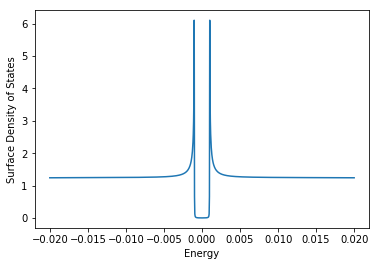

In [5]:
# testing the surface_g code
# test of the Hamiltonian function
params = {
    "N_z" : 10,
    "N_phi" : 1,
    "flux" : 0e0,
    "t_z" : 1000e-3,
    "Delta" : 1e-3,
    "mu" : 100e-3,
}

params["t_phi"] = 0e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])


H = calc_hamiltonian(params)
surface_dof = 2*params['N_phi']
alpha = H[:surface_dof,:surface_dof]
beta = H[:surface_dof,surface_dof:2*surface_dof]

E = np.linspace(-20e-3,20e-3,1000)
eta = 0.1*np.abs(E[1]-E[0])
g = calc_surface_g(E,alpha,beta,eta)
a = 1j*(g - np.conj(np.transpose(g,(0,2,1))))
dos = np.real(np.trace(a,axis1=-1,axis2=-2))

plt.plot(E,dos)
plt.xlabel("Energy")
plt.ylabel("Surface Density of States")

In [67]:
def calc_sns_negf(E,params):
    '''
    Returns the G,A,Sigma matrices for SNS device. The chemical potential will be assumed to same everywhere and
    no bias is present across the device.
    params dict takes in these parameters:
        N_z : number of points along z in the normal region
        N_phi : number of points along azimuthal direction
        t_z : h^2/(2 m a^2), where a is lattice spacing
        t_phi : h^2/(2 m R^2), where a is lattice spacing
        mu : chemical potential
        Delta_1 : superconducting parameter 1
        Delta_2 : superconducting parameter 2
        eta : imaginary 0+ added for convergence
    '''
    N_z = params['N_z']
    N_phi = params['N_phi']
    t_z = params['t_z']
    t_phi = params['t_phi']
    Delta_1 = params['Delta_1']
    Delta_2 = params['Delta_2']
    mu = params['mu']
    eta = params['eta']
    flux = params['flux']
    kT = params['kT']
    
    # create alpha/beta hamiltonians for S regions
    # calc surface Green's function
   
    params_S1 = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z,"N_phi" : N_phi, "Delta" : Delta_1, "mu" : mu,"flux" : flux}
    H_S1 = calc_hamiltonian(params_S1)   
    surface_dof = 2*N_phi
    alpha_1 = H_S1[:surface_dof,:surface_dof]
    beta_1 = H_S1[:surface_dof,surface_dof:2*surface_dof]
    g_1 = calc_surface_g(E,alpha_1,beta_1,eta)
    
    params_S2 = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z,"N_phi" : N_phi, "Delta" : Delta_2, "mu" : mu,"flux" : flux}
    H_S2 = calc_hamiltonian(params_S2)   
    surface_dof = 2*N_phi
    alpha_2 = H_S2[:surface_dof,:surface_dof]
    beta_2 = H_S2[:surface_dof,surface_dof:2*surface_dof]
    g_2 = calc_surface_g(E,alpha_2,beta_2,eta)
    
    
    # create Hamiltonian for N region
    params_N = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z,"N_phi" : N_phi, "Delta" : 0, "mu" : mu,"flux" : flux}
    H_mat = calc_hamiltonian(params_N)
    
    #number of dof in a layer
    N_dof_lat = N_phi*2
    # the hopping element between layers
    beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]
    
    # the only non-zero elements in sigma
    sigma_mini_1 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_1@beta_layer
    sigma_mini_2 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_2@beta_layer
    
    sigma_1 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
    sigma_1[:,:N_dof_lat,:N_dof_lat] = sigma_mini_1
    gamma_1 = 1j*(sigma_1 - np.transpose(np.conj(sigma_1),(0,2,1)))
    
    sigma_2 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
    sigma_2[:,-N_dof_lat:,-N_dof_lat:] = sigma_mini_2
    gamma_2 = 1j*(sigma_2 - np.transpose(np.conj(sigma_2),(0,2,1)))
    
    # NEGF matrices
    G = np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2)
    
    A = 1j*(G - np.transpose(np.conj(G),(0,2,1))) 
    dos = np.real(np.trace(A,axis1=-2,axis2=-1))
    
    def fermi(E,kT):
        return scipy.special.expit(-E/kT)
    
    def generate_fermi_matrix(E,mu,kT):
        return np.array([[[fermi(ele - mu,kT),0],[0,fermi(ele + mu,kT)]] for ele in E])
        
    F1 = np.kron(np.eye(N_phi*N_z),generate_fermi_matrix(E,mu-mu,kT))
    F2 = np.kron(np.eye(N_phi*N_z),generate_fermi_matrix(E,mu-mu,kT))
    sigma_in = np.matmul(gamma_1,F1) + np.matmul(gamma_2,F2)
    
    G_n = np.matmul(G,np.matmul(sigma_in,np.transpose(np.conj(G),(0,2,1))))
    
    #I_mat = 1j*(np.matmul(G_n[:N_dof_lat,N_dof_lat:2*N_dof_lat],beta_layer) \
    #         - np.matmul(G_n[N_dof_lat:2*N_dof_lat,:N_dof_lat],beta_layer))
    I_mat = 1j*(np.matmul(H_mat,G_n) - np.matmul(G_n,H_mat))
    # current = electron current - hole current
    I = np.real(np.trace(I_mat[:,0:2*N_phi:2,0:2*N_phi:2]-I_mat[:,1:2*N_phi:2,1:2*N_phi:2],axis1=-1,axis2=-2))
    
    return G,A,dos,I

In [70]:
# testing the dos code
params = {
    "N_z" : 2,
    "N_phi" : 1,
    "flux" : 0e0,
    "t_z" : 1000e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3*np.exp(1j*np.pi/2),
    "mu" : 100e-3,
    "kT" : 1e-5,
}

params["t_phi"] = 5e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])
E_vec = np.linspace(-2e-3,2e-3,50)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

G,A,dos,I = calc_sns_negf(E_vec,params)
print(I)

[ 4.58087422e-02  5.39709642e-02  6.41189792e-02  7.69132661e-02
  9.33063665e-02  1.14709400e-01  1.43282677e-01  1.82461143e-01
  2.37963041e-01  3.19853708e-01  4.47124477e-01  6.58876704e-01
  1.04475111e+00  1.84194177e+00  3.83700979e+00  9.90834225e+00
  1.68799475e+01  7.42925716e+00  3.01510581e+00  1.50216303e+00
  8.51453048e-01  5.12765943e-01  3.07796513e-01  1.65675876e-01
  5.15425788e-02 -8.70032759e-04 -7.96833638e-07 -4.21804300e-10
 -2.00219053e-13 -9.47296340e-17 -4.76190960e-20 -2.72336317e-23
 -1.91199748e-26 -1.23780417e-29 -2.07024036e-33 -2.28429191e-37
 -3.12444953e-41 -5.04951170e-45 -9.07359971e-49 -1.75445742e-52
 -3.57605920e-56 -7.58056791e-60 -1.65615717e-63 -3.70564461e-67
 -8.45294440e-71 -1.95911173e-74 -4.60138003e-78 -1.09298040e-81
 -2.62134916e-85 -6.33945592e-89]


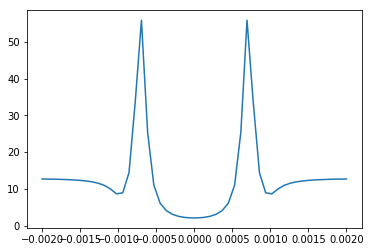

In [71]:
plt.plot(E_vec,dos)

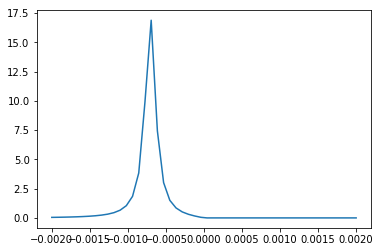

In [72]:
plt.plot(E_vec,I)

## Dos vs phase map

In [75]:
# testing the dos code
params = {
    "N_z" : 2,
    "N_phi" : 1,
    "flux" : 0e0,
    "t_z" : 1000e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 100e-3,
    "kT" : 1e-5,
}
params["t_phi"] = 5e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])
E_vec = np.linspace(-2e-3,2e-3,100)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

dos_arr = []
I_arr = []
phi_vec = np.linspace(0,2*np.pi,100)
for phi in phi_vec:
    params['Delta_2'] = params['Delta_1']*np.exp(1j*phi)
    G,A,dos,I = calc_sns_negf(E_vec,params)
    dos_arr.append(dos)
    I_arr.append(I)

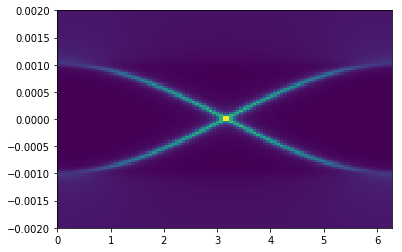

In [76]:
dos_arr = np.array(dos_arr).T
XX,YY = np.meshgrid(phi_vec,E_vec)
plt.pcolor(XX,YY,dos_arr)

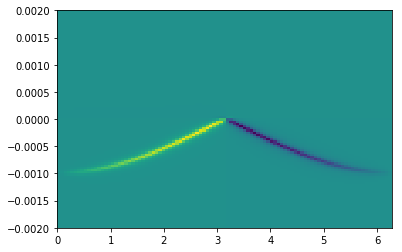

In [77]:
# DOS vs current map
I_arr = np.array(I_arr).T
XX,YY = np.meshgrid(phi_vec,E_vec)
plt.pcolor(XX,YY,I_arr)

In [78]:
## Current phase

In [87]:
def integrate_current(E_vec,I_vec):
    return scipy.integrate.simps(I_vec,E_vec) 

def calc_I_phi(params,E_vec,phi_vec):
    I_phi = []
    for phi in phi_vec:
        params['Delta_2'] = params['Delta_1']*np.exp(1j*phi)
        G,A,dos,I = calc_sns_negf(E_vec,params)
        I_phi.append(integrate_current(E_vec,I))
    I_phi = np.array(I_phi)
    return I_phi

In [130]:
# testing the dos code
params = {
    "N_z" : 2,
    "N_phi" : 1,
    "flux" : 0e0,
    "t_z" : 1000e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 0e-3,
    "kT" : 1e-5,
}
params["t_phi"] = 5e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])
E_vec = np.linspace(-2e-3,2e-3,100)
phi_vec = np.linspace(0,2*np.pi,100)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

I_phi = calc_I_phi(params,E_vec,phi_vec)

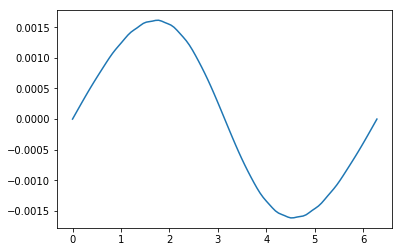

In [131]:
plt.plot(phi_vec,I_phi)

## Study of current phase relation with changing chemical potential

In [91]:
params = {
    "N_z" : 2,
    "N_phi" : 1,
    "flux" : 0e0,
    "t_z" : 1000e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 100e-3,
    "kT" : 1e-5,
}
params["t_phi"] = 5e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])
E_vec = np.linspace(-2e-3,2e-3,100)
phi_vec = np.linspace(0,2*np.pi,100)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

mu_vec = np.linspace(10e-3,100e-3,100)
I_arr = []
for mu in mu_vec:
    print(mu)
    params['mu'] = mu
    I_arr.append(calc_I_phi(params,E_vec,phi_vec))
I_arr = np.array(I_arr)

0.01
0.01090909090909091
0.011818181818181818
0.012727272727272728
0.013636363636363637
0.014545454545454545
0.015454545454545455
0.016363636363636365
0.017272727272727273
0.01818181818181818
0.019090909090909092
0.020000000000000004
0.020909090909090912
0.02181818181818182
0.022727272727272728
0.023636363636363636
0.024545454545454547
0.02545454545454546
0.026363636363636367
0.027272727272727275
0.028181818181818183
0.02909090909090909
0.030000000000000006
0.030909090909090914
0.03181818181818182
0.03272727272727273
0.03363636363636364
0.034545454545454546
0.03545454545454546
0.03636363636363637
0.03727272727272728
0.038181818181818185
0.03909090909090909
0.04
0.040909090909090916
0.041818181818181824
0.04272727272727273
0.04363636363636364
0.044545454545454555
0.04545454545454546
0.04636363636363637
0.04727272727272728
0.04818181818181819
0.049090909090909095
0.05000000000000001
0.05090909090909092
0.051818181818181826
0.052727272727272734
0.05363636363636364
0.05454545454545455
0.05

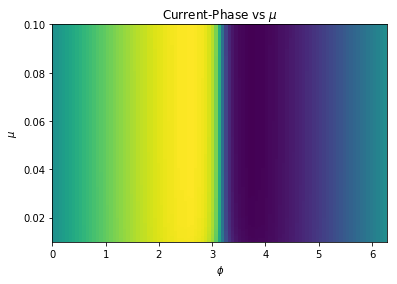

In [114]:
XX,YY = np.meshgrid(phi_vec,mu_vec)
plt.pcolor(XX,YY,I_arr)
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.title("Current-Phase vs $\mu$")

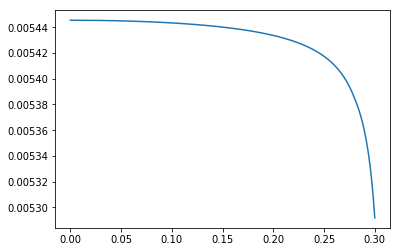

In [129]:
plt.plot(np.sqrt(100e-3 - mu_vec),np.max(I_arr,axis=1))

# Notes
 - I am unsure how to incorporate the flux term in the diagonal element.
 - The spectrum is too slow to compute with finite-cross section, this looks like a design flaw
 - Are $l \neq 0$ states different in energies from $l = 0$ states in the absence of a B field?
 - How do l states evolve as a function of $\mu$? More importantly, what the right chemical potential so that only $l = 0,1$ are populated?
 - The current phase relationship does not change as a function of $\mu$. Since adding a B-field to a 1D nanowire only chnages $\mu$, I do not expect to see any change as a function of B.
 
 **Observation** : Low $\mu$ is hard to converge. I don't know why?

# Intersting Asides
1. Visualisation of surface density of states in $\mu$-$\Delta$ space. I see that for $t \gg \mu \gg \Delta$, the dos outside the gap is almost flat. 

In [43]:
params = {
    "N_z" : 10,
    "N_phi" : 1,
    "flux" : 0e0,
    "t_z" : 1000e-3,
    "Delta" : 1e-3,
    "mu" : 100e-3,
}

params["t_phi"] = 0e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])

E = np.linspace(-10e-3,10e-3,1000)
eta = 0.1*np.abs(E[1]-E[0])

mu_vec = np.linspace(0,100e-3,25) 
data = []
for mu in mu_vec:
    params['mu'] = mu
    
    H = calc_hamiltonian(params)
    surface_dof = 2*params['N_phi']
    alpha = H[:surface_dof,:surface_dof]
    beta = H[:surface_dof,surface_dof:2*surface_dof]
    
    g = calc_surface_g(E,alpha,beta,eta)
    a = 1j*(g - np.conj(np.transpose(g,(0,2,1))))
    dos = np.real(np.trace(a,axis1=-1,axis2=-2))

    data.append(dos)
data = np.array(data)

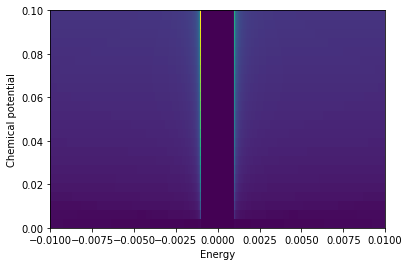

In [44]:
XX,YY = np.meshgrid(E,mu_vec)
plt.pcolor(XX,YY,data)
plt.xlabel("Energy")
plt.ylabel("Chemical potential")

In [46]:
a = np.eye(2)

def f():
    return np.array([[1,0],[0,-1]])

print(np.kron(a,f()))

[[ 1.  0.  0.  0.]
 [ 0. -1.  0. -0.]
 [ 0.  0.  1.  0.]
 [ 0. -0.  0. -1.]]
